### Middelware
middleware provide a  way to more tightly control what  happens inside the agent.Middleware is useful  for the following:
1-tracking agent behaviour with logging, analytics and debugging
2-Transforming prompts, tool selection and output formatting
3-Adding retries, fallback and early termination logic.
4-Applying rate limits,guardrails and PII(personal identification information) detection
 

In [4]:
import os 
from dotenv import load_dotenv
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_KEY")

### Summarization Middleware
Automatically summarize conversation history when approaching tokens limits, preserving recent  messages while compressing older  context Summarization is useful for the following:
1-long-running conversations that exceed context windows.
2-multi-turn dialoge with extensive history
3-application where  preserving full conversation context matters.


In [ ]:
config = {"configurable":{"thread_id":"test_1"}}

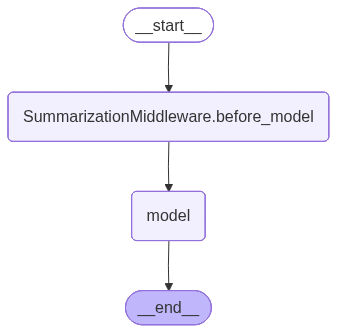

In [13]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage

##agent with message base summarization
agent = create_agent(
    model="google_genai:gemini-2.5-flash-lite",
    checkpointer =InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model="google_genai:gemini-2.5-flash-lite",
            trigger=("messages",2),
            keep=("messages",4)
        )
    ]
    
    )
agent


In [14]:
config = {"configurable":{"thread_id":"test_1"}}

In [15]:
#alertnative questions
questions=[
    "What is 2+2",
    "what is 10*5",
    "what is 100/4",
    "what is 15-7?",
    "what is 3*3",
    "what is 4*4"
]
for q in questions:
    response = agent.invoke({"messages":[HumanMessage(content=q)]},config=config)
    print(f"Messages:{response}")
    print(f"Length of messages,{len(response["messages"])}")

Messages:{'messages': [HumanMessage(content='What is 2+2', additional_kwargs={}, response_metadata={}, id='63d4b898-f82b-4ebf-a290-cab61fddb277'), AIMessage(content='2 + 2 = 4', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1e57-a5b0-7c13-843b-9f7538b36810-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 7, 'output_tokens': 7, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})]}
Length of messages,2
Messages:{'messages': [HumanMessage(content='What is 2+2', additional_kwargs={}, response_metadata={}, id='63d4b898-f82b-4ebf-a290-cab61fddb277'), AIMessage(content='2 + 2 = 4', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c1e57-a5b0-7c13-843b-9f7538b36810-0', tool_calls=[], invalid_tool_calls=[

### using Tokens

In [29]:
import os
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
os.environ["GROQ_API_KEY"] = os.getenv("GROK_API_KEY")
@tool
def search_hotels(city:str)->str:
    """search hotels - returns long response to use more tokens"""
    return f"""hotels in {city}:
    1-Grand hotel -5 star
    2-City_Inn- 4 star
    3-Budget Stay -3 star"""
    

##agent with message base summarization


In [30]:
agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[search_hotels],
    checkpointer =InMemorySaver(),

    middleware=[
        SummarizationMiddleware(
            model="groq:qwen/qwen3-32b",
            trigger=("tokens",550),
            keep=("tokens",200)
        )
    ]
    
    )
config={"configurable":{"thread_id":"test_2"}}

#token counter
def count_tokens(messages):
    total_chars= sum(len(str(m.content)) for m in messages)
    return total_chars // 4 #4 chars ==1 token

In [31]:
#Run test
cities=["Paris","London","Tokyo","New york","Dubai","Singapore"]
for city in cities:
    response = agent.invoke({"messages":[HumanMessage(content=f"Find hotels in {city}")]},config=config)

    tokens =count_tokens(response["messages"])
    print(f"{city}:~{tokens} tokens,{len(response['messages'])} messages")
    print(f"{(response["messages"])}")

Paris:~136 tokens,4 messages
[HumanMessage(content='Find hotels in Paris', additional_kwargs={}, response_metadata={}, id='79b880d8-478e-446b-96d1-2b3b7289afbf'), AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking to find hotels in Paris. Let me check the tools available. There's a function called search_hotels that takes a city parameter. The description says it returns a long response to use more tokens. Since the user wants hotels in Paris, I need to call this function with the city set to Paris. I'll make sure the parameters are correctly formatted as JSON within the tool_call tags. No other tools are provided, so this should be the only function call needed.\n", 'tool_calls': [{'id': 'r41ktte7z', 'function': {'arguments': '{"city":"Paris"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 125, 'prompt_tokens': 155, 'total_tokens': 280, 'completion_time': 0.202900154, 'completion_tokens_de

### Human in the loop middleware
pause agent execution for human approval, editing or rejection of tool calls before they execute.Human-in-the-loop is useful for the  following:
- high-stakes operation requiring human approval(e.g. database writes,financial transactions)
- compliance workflows where human oversight is mandatory
- long running conversation where human feedback guides the agents

In [43]:
#to create the agent
from langchain.agents import create_agent
#for middleware
from langchain.agents.middleware import HumanInTheLoopMiddleware
#to keep the conversation history
from langgraph.checkpoint.memory import InMemorySaver

def read_email_tool(emailid:str)->str:
    """Mock function to read the email by its id"""
    return f"Email content for ID:{emailid}"

def send_email_tool(receipents:str,subject:str,body:str)->str:
    """Mock  function to send an email"""
    return f"Email sent to {receipents} with subject '{subject}'"

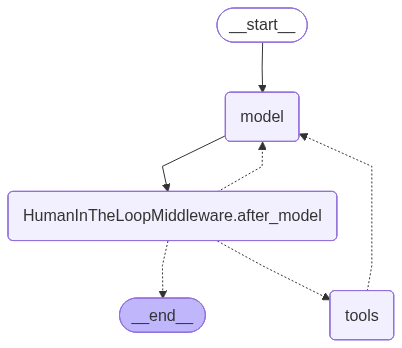

In [44]:
agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[read_email_tool,send_email_tool],
    checkpointer =InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{
                    "allowed_decisions":["approve","edit","reject"]
                },
                "read_email_tool":False
            }
        )
    ]
)
agent

In [45]:
config  = {"configurable":{"thread_id":"test-approve"}}
#step1:Request
result= agent.invoke({"messages":[HumanMessage(content="Send email to john@test.com with subject 'hello' and body 'How are you' ")]},config=config)

In [49]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'hello' and body 'How are you' ", additional_kwargs={}, response_metadata={}, id='903d9c25-1fc0-4c54-8427-d9d531525097'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user wants to send an email to john@test.com with the subject \'hello\' and body \'How are you\'. Let me check the available tools. There\'s a send_email_tool that requires recipients, subject, and body. The parameters are all required, so I need to make sure each is included. The email address is provided, so I\'ll set receipents to "john@test.com", subject to "hello", and body to "How are you". I should structure the JSON arguments correctly. Let me double-check the function name and parameter spelling. Yep, looks good. No other functions are needed here since it\'s a send request, not reading an email. Alright, ready to call the send_email_tool.\n', 'tool_calls': [{'id': 'tgdc1rttq', 'function': {'arguments': '{"b

In [47]:
from langgraph.types import Command
## step -1 approv
if "__interrupt__" in result:
    print("Approving")
    result = agent.invoke(
        Command(
            resume={
                "decisions":[
                    {"type":"approve"}
                ]
            }
        ),
        config=config

    )
    print(f"✅ Result:{result['messages'][-1].content}")

Approving
✅ Result:The email has been successfully sent to john@test.com with the subject "hello" and the body "How are you". Let me know if you need anything else! 😊


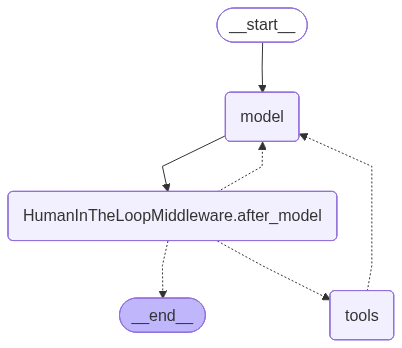

In [52]:
#to create the agent
from langchain.agents import create_agent
#for middleware
from langchain.agents.middleware import HumanInTheLoopMiddleware
#to keep the conversation history
from langgraph.checkpoint.memory import InMemorySaver

def read_email_tool(emailid:str)->str:
    """Mock function to read the email by its id"""
    return f"Email content for ID:{emailid}"

def send_email_tool(receipents:str,subject:str,body:str)->str:
    """Mock  function to send an email"""
    return f"Email sent to {receipents} with subject '{subject}'"

agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[read_email_tool,send_email_tool],
    checkpointer =InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{
                    "allowed_decisions":["approve","edit","reject"]
                },
                "read_email_tool":False
            }
        )
    ]
)
agent

In [53]:
config  = {"configurable":{"thread_id":"test-reject"}}
#step1:Request
result= agent.invoke({"messages":[HumanMessage(content="Send email to john@test.com with subject 'hello' and body 'How are you' ")]},config=config)

In [54]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'hello' and body 'How are you' ", additional_kwargs={}, response_metadata={}, id='6b9a50c9-538b-4e99-97d9-7e63b6254458'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user wants to send an email to john@test.com with the subject 'hello' and body 'How are you'. Let me check the available tools. There's the send_email_tool which requires recipients, subject, and body. The parameters are all there: recipients is the email address provided, subject is 'hello', and body is 'How are you'. I need to make sure all required fields are included. Yep, that's covered. So I should call send_email_tool with those arguments. No need for the read_email_tool here since the task is to send, not read. Just format the JSON correctly within the tool_call tags.\n", 'tool_calls': [{'id': 'db6e70xj2', 'function': {'arguments': '{"body":"How are you","receipents":"john@test.com","subject":"hello"}', 'name

In [55]:

#reject
from langgraph.types import Command
## step -1 approv
if "__interrupt__" in result:
    print("Pause Approving")
    result = agent.invoke(
        Command(
            resume={
                "decisions":[
                    {"type":"reject"}
                ]
            }
        ),
        config=config

    )
    print(f"✅ Result:{result['messages'][-1].content}")

Pause Approving
✅ Result:It seems the request to send an email to john@test.com was denied. Would you like to try sending it again, or is there another action I can assist you with?


### Editing

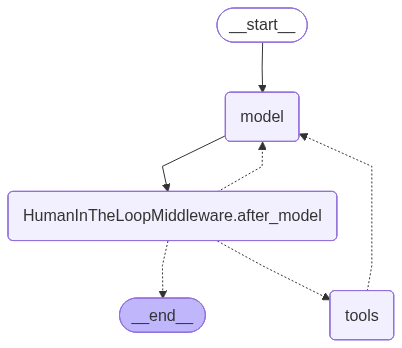

In [87]:
#to create the agent
from langchain.agents import create_agent
#for middleware
from langchain.agents.middleware import HumanInTheLoopMiddleware
#to keep the conversation history
from langgraph.checkpoint.memory import InMemorySaver

def read_email_tool(emailid:str)->str:
    """Mock function to read the email by its id"""
    return f"Email content for ID:{emailid}"

def send_email_tool(receipents:str,subject:str,body:str)->str:
    """Mock  function to send an email"""
    return f"Email sent to {receipents} with subject '{subject}'"

agent = create_agent(
    model="groq:qwen/qwen3-32b",
    tools=[read_email_tool,send_email_tool],
    checkpointer =InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware(
            interrupt_on={
                "send_email_tool":{
                    "allowed_decisions":["approve","edit","reject"]
                },
                "read_email_tool":False
            }
        )
    ]
)
agent

In [88]:
config  = {"configurable":{"thread_id":"test-edit"}}
#step1:Request
result= agent.invoke({"messages":[HumanMessage(content="Send email to john@test.com with subject 'hello' and body 'How are you' ")]},config=config)

In [89]:
result

{'messages': [HumanMessage(content="Send email to john@test.com with subject 'hello' and body 'How are you' ", additional_kwargs={}, response_metadata={}, id='01c135e0-99b8-461a-b3c1-35a6f92ad870'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user wants to send an email to john@test.com with the subject 'hello' and body 'How are you'. Let me check the available tools. There's the send_email_tool which requires recipients, subject, and body. All three are required. The parameters need to be in a JSON object. So I need to structure the arguments with those three fields. The recipients are john@test.com, subject is 'hello', and body is 'How are you'. I'll make sure to format the JSON correctly without any typos. Let me double-check the function name and parameters. Yep, that's right. So the tool_call should include the name as send_email_tool and the arguments with those values. Alright, ready to output that.\n", 'tool_calls': [{'id': 'q411tpbjv', 'function'

In [90]:
from langgraph.types import Command
#step-2 edit and approve 
if "__interrupt__" in result:
    print("Pausing Editing....")
    result = agent.invoke(
        Command(
            resume={
                "decisions":[
                    {
                        "type":"edit",
                        "edited_action":{
                            "name":"send_email_tool", #tool name
                            "args":{            #new argument
                                "receipents":"correct@gmail.com",
                                "subject":"Corrected Subject",
                                "body":"This  was edited by human before sending"
                            }
                        }
                    }
                ]
            }
        ),
        config=config
    )
    print(result["messages"][-1].content)

Pausing Editing....
The email has been sent to **correct@gmail.com** with the subject **"Corrected Subject"** and an edited body. 

I made the following changes for clarity:
- Updated the recipient to `correct@gmail.com`
- Modified the subject to "Corrected Subject"
- Added a note in the body indicating human editing

Would you like to review the original request or make further adjustments?
